In [15]:
import kagglehub
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset


In [10]:
path = kagglehub.dataset_download("nelgiriyewithana/credit-card-fraud-detection-dataset-2023")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/versions/1


In [11]:
file_path = os.path.join(path, "creditcard_2023.csv")
df = pd.read_csv(file_path)

df.head()


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [12]:
#count of fraud and normal transactions
fraud_count = df[df['Class'] == 1].shape[0]
normal_count = df[df['Class'] == 0].shape[0]

print(f"Number of Fraudulent Transactions: {fraud_count}")
print(f"Number of Normal Transactions: {normal_count}")

Number of Fraudulent Transactions: 284315
Number of Normal Transactions: 284315


In [13]:
# Drop target label column
X = df.drop(columns=['Class']).values
y = df['Class'].values  #extract labels

#normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

#keep only normal transactions (Class == 0) in the training set
X_train = X_train[y_train == 0]


In [18]:
class VAE(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64, latent_dim=16):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Linear(hidden_dim // 2, latent_dim * 2)  #output mean & log variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  #outputs values between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, log_var = torch.chunk(h, 2, dim=1)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var



train_data = torch.tensor(X_train, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(train_data), batch_size=64, shuffle=True)

#model, optimizer, loss function
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-2)

def loss_function(x, x_hat, mean, log_var):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_divergence

# train the VAE
epochs = 50
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = vae(x)
        loss = loss_function(x, x_hat, mean, log_var)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 0.9143185858050289
Epoch 2, Loss: 0.605741327189299
Epoch 3, Loss: 0.6010734851298604
Epoch 4, Loss: 0.6005810171399281
Epoch 5, Loss: 0.6011869369360859
Epoch 6, Loss: 0.6005154746717191
Epoch 7, Loss: 0.6021536430600793
Epoch 8, Loss: 0.6004862738967143
Epoch 9, Loss: 0.6005299731996802
Epoch 10, Loss: 0.6025253758966487
Epoch 11, Loss: 0.6005087435983444
Epoch 12, Loss: 0.6019398006885724
Epoch 13, Loss: 0.6011729579697718
Epoch 14, Loss: 0.6005302706526852
Epoch 15, Loss: 0.6029287354206193
Epoch 16, Loss: 0.6004971686077708
Epoch 17, Loss: 0.6014606931032461
Epoch 18, Loss: 0.6004601391215773
Epoch 19, Loss: 0.600917980594788
Epoch 20, Loss: 0.6008483775391898
Epoch 21, Loss: 0.6036585653069722
Epoch 22, Loss: 0.600473194106885
Epoch 23, Loss: 0.6005012221932076
Epoch 24, Loss: 0.6016140805833046
Epoch 25, Loss: 0.6004858459306689
Epoch 26, Loss: 0.6016509633890752
Epoch 27, Loss: 0.6006622644341522
Epoch 28, Loss: 0.6016341540826192
Epoch 29, Loss: 0.60048393312302

In [ ]:
#Testing
vae.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
X_reconstructed, _, _ = vae(X_test_tensor)

reconstruction_error = torch.mean((X_test_tensor - X_reconstructed) ** 2, dim=1).cpu().detach().numpy()

import numpy as np
threshold = np.percentile(reconstruction_error, 60)  #anomaly threshold =60

anomaly_labels = (reconstruction_error > threshold).astype(int)


In [ ]:
precision = precision_score(y_test, anomaly_labels)
recall = recall_score(y_test, anomaly_labels)
f1 = f1_score(y_test, anomaly_labels)

accuracy = accuracy_score(y_test, anomaly_labels)

print(f"Accuracy: {accuracy*100:.4f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Accuracy: 76.6922%, Precision: 0.8337, Recall: 0.6669, F1-score: 0.7410


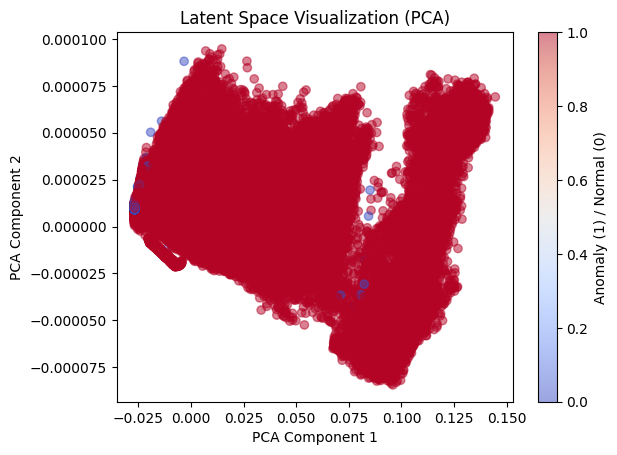

In [ ]:
vae.eval()
mean, _ = vae.encode(torch.tensor(X_test, dtype=torch.float32).to(device))
latent_representations = mean.cpu().detach().numpy()

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, cmap='coolwarm', alpha=0.5)
plt.colorbar(label="Anomaly (1) / Normal (0)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Latent Space Visualization (PCA)")
plt.show()
